In [2]:
import gc
gc.collect()

7

In [ ]:
import pandas as pd
import os

file_labels = {
    "./DrDoS_LDAP.csv": "DrDoS_LDAP",
    "./DrDoS_MSSQL.csv": "DrDoS_MSSQL",
    "./DrDoS_NetBIOS.csv": "DrDoS_NetBIOS",
    "./DrDoS_NTP.csv": "DrDoS_NTP",
    "./DrDoS_SNMP.csv": "DrDoS_SNMP",
    "./DrDoS_SSDP.csv": "DrDoS_SSDP",
    "./DrDoS_UDP.csv": "DrDoS_UDP",
}

def summarize_labels(file_labels):
    for file, label in file_labels.items():
        if os.path.exists(file):
            print(f"Đang xử lý file: {file}")
            
            chunk = pd.read_csv(file, low_memory=False)

            print(f"Tên các cột trong file {file}: {chunk.columns.tolist()}")

            chunk.columns = chunk.columns.str.strip().str.replace('[^A-Za-z0-9_]', '_', regex=True)

            if 'Label' in chunk.columns:
                unique_labels = chunk["Label"].unique()
                label_counts = chunk["Label"].value_counts()

                null_labels = chunk["Label"].isnull().sum()
                print(f"Số lượng giá trị null trong cột 'Label': {null_labels}")

                print(f"Unique labels in {file}: {unique_labels}")
                print(f"Label counts in {file}:\n{label_counts}\n")
            else:
                print(f"Cột 'Label' không tồn tại trong file {file}\n")
        else:
            print(f"File {file} không tồn tại.\n")

summarize_labels(file_labels)


Đang xử lý file: ./DrDoS_LDAP.csv
Tên các cột trong file ./DrDoS_LDAP.csv: ['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', '

In [5]:
import gc
gc.collect()

60

In [ ]:
import pandas as pd
import os
from sklearn.utils import shuffle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib

pd.set_option('display.max_columns', None)

file_labels = {
    "./DrDoS_LDAP.csv": "DrDoS_LDAP",
    "./DrDoS_MSSQL.csv": "DrDoS_MSSQL",
    "./DrDoS_NetBIOS.csv": "DrDoS_NTP",
    "./DrDoS_SNMP.csv": "DrDoS_SNMP",
    "./DrDoS_SSDP.csv": "DrDoS_SSDP",
    "./DrDoS_UDP.csv": "DrDoS_UDP",
}

ROWS_PER_CLASS = 200000

all_data = []

def clean_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^\w]', '', regex=True)
    return df

def process_file(file_path):
    benign_rows = []
    attack_rows = []

    chunksize = 100000
    for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
        chunk = clean_columns(chunk)

        if 'label' not in chunk.columns:
            continue

        benign_chunk = chunk[chunk['label'].str.lower() == 'benign']
        attack_chunk = chunk[chunk['label'].str.lower() != 'benign']

        benign_rows.append(benign_chunk)
        attack_rows.append(attack_chunk)

        if sum(len(df) for df in benign_rows) >= ROWS_PER_CLASS and \
           sum(len(df) for df in attack_rows) >= ROWS_PER_CLASS:
            break

    benign_df = pd.concat(benign_rows).head(ROWS_PER_CLASS)
    attack_df = pd.concat(attack_rows).head(ROWS_PER_CLASS)

    combined = pd.concat([benign_df, attack_df], ignore_index=True)
    return combined

for file_path, label in file_labels.items():
    print(f"Processing: {label}")
    df = process_file(file_path)
    df['attack_type'] = label
    all_data.append(df)

final_df = pd.concat(all_data, ignore_index=True)
final_df = clean_columns(final_df)

# Loại bỏ vô cùng, thay NaN bằng trung bình (chỉ cột số)
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_cols = final_df.select_dtypes(include='number').columns
final_df[numeric_cols] = final_df[numeric_cols].fillna(final_df[numeric_cols].mean())

# Trộn dữ liệu
final_df = shuffle(final_df, random_state=42)

scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

scaled_data = scaler.fit_transform(final_df[numeric_cols]) 
imputed_data = imputer.fit_transform(scaled_data)

joblib.dump(scaler, "DrDoS_scaler.pkl")
joblib.dump(imputer, "DrDoS_imputer.pkl")

output_path = "./processed_dataset.csv"
final_df[numeric_cols] = imputed_data 
final_df.to_csv(output_path, index=False)

print(f"Saved to: {output_path}")
print(final_df.head())


Processing: DrDoS_LDAP
Processing: DrDoS_MSSQL
Processing: DrDoS_NTP
Processing: DrDoS_SNMP
Processing: DrDoS_SSDP
Processing: DrDoS_UDP
Saved to: ./processed_dataset.csv
        unnamed_0                                 flow_id   source_ip  \
572998   2.054131    172.16.0.5-192.168.50.1-815-41417-17  172.16.0.5   
887818  -0.566517  172.16.0.5-192.168.50.1-41365-43619-17  172.16.0.5   
726333   1.919912     172.16.0.5-192.168.50.1-850-9680-17  172.16.0.5   
812815  -0.662597    172.16.0.5-192.168.50.1-967-14151-17  172.16.0.5   
479636  -0.467321    172.16.0.5-192.168.50.1-648-55511-17  172.16.0.5   

        source_port destination_ip  destination_port  protocol  \
572998    -0.905713   192.168.50.1          0.457196  0.079939   
887818     0.740906   192.168.50.1          0.573176  0.079939   
726333    -0.904292   192.168.50.1         -1.214398  0.079939   
812815    -0.899541   192.168.50.1         -0.978909  0.079939   
479636    -0.912494   192.168.50.1          1.199530  0.0799

In [7]:
import gc
gc.collect()

0

In [ ]:
import pandas as pd

def hien_thi_toan_bo_cot():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.expand_frame_repr', False)
    print(" Đã cấu hình để hiển thị toàn bộ cột.")

def hien_thi_ten_cot(df):
    print(f"\n Tổng số cột: {len(df.columns)}\n")
    for i, col in enumerate(df.columns):
        print(f"{i+1:>3}. {col}")

df = pd.read_csv("./processed_dataset.csv")

hien_thi_toan_bo_cot()
hien_thi_ten_cot(df)
print("\n📄 Xem thử 3 dòng đầu:")
print(df.head(3))


C:\Users\VennDev\AppData\Local\Temp\ipykernel_528\3846213402.py:14: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./processed_dataset.csv")


 Đã cấu hình để hiển thị toàn bộ cột.

 Tổng số cột: 89

  1. unnamed_0
  2. flow_id
  3. source_ip
  4. source_port
  5. destination_ip
  6. destination_port
  7. protocol
  8. timestamp
  9. flow_duration
 10. total_fwd_packets
 11. total_backward_packets
 12. total_length_of_fwd_packets
 13. total_length_of_bwd_packets
 14. fwd_packet_length_max
 15. fwd_packet_length_min
 16. fwd_packet_length_mean
 17. fwd_packet_length_std
 18. bwd_packet_length_max
 19. bwd_packet_length_min
 20. bwd_packet_length_mean
 21. bwd_packet_length_std
 22. flow_bytess
 23. flow_packetss
 24. flow_iat_mean
 25. flow_iat_std
 26. flow_iat_max
 27. flow_iat_min
 28. fwd_iat_total
 29. fwd_iat_mean
 30. fwd_iat_std
 31. fwd_iat_max
 32. fwd_iat_min
 33. bwd_iat_total
 34. bwd_iat_mean
 35. bwd_iat_std
 36. bwd_iat_max
 37. bwd_iat_min
 38. fwd_psh_flags
 39. bwd_psh_flags
 40. fwd_urg_flags
 41. bwd_urg_flags
 42. fwd_header_length
 43. bwd_header_length
 44. fwd_packetss
 45. bwd_packetss
 46. min_packet

 Số lượng mẫu theo nhãn:
label
DrDoS_NetBIOS    200000
DrDoS_SSDP       200000
DrDoS_SNMP       200000
DrDoS_LDAP       200000
DrDoS_MSSQL      200000
DrDoS_UDP        200000
BENIGN             9752
Name: count, dtype: int64

 Tỷ lệ phần trăm mỗi nhãn:
label
DrDoS_NetBIOS    16.53
DrDoS_SSDP       16.53
DrDoS_SNMP       16.53
DrDoS_LDAP       16.53
DrDoS_MSSQL      16.53
DrDoS_UDP        16.53
BENIGN            0.81
Name: count, dtype: float64


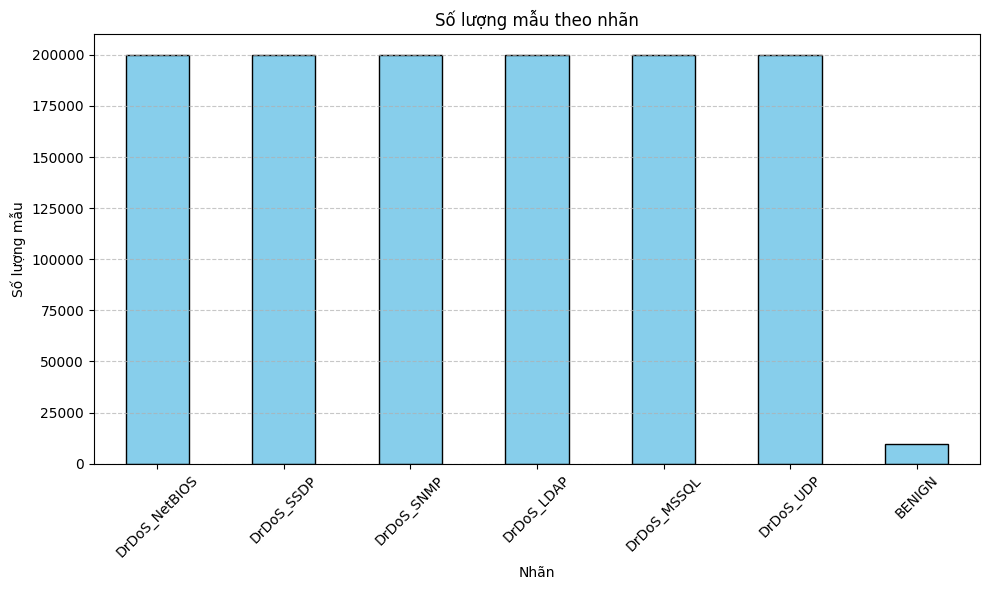

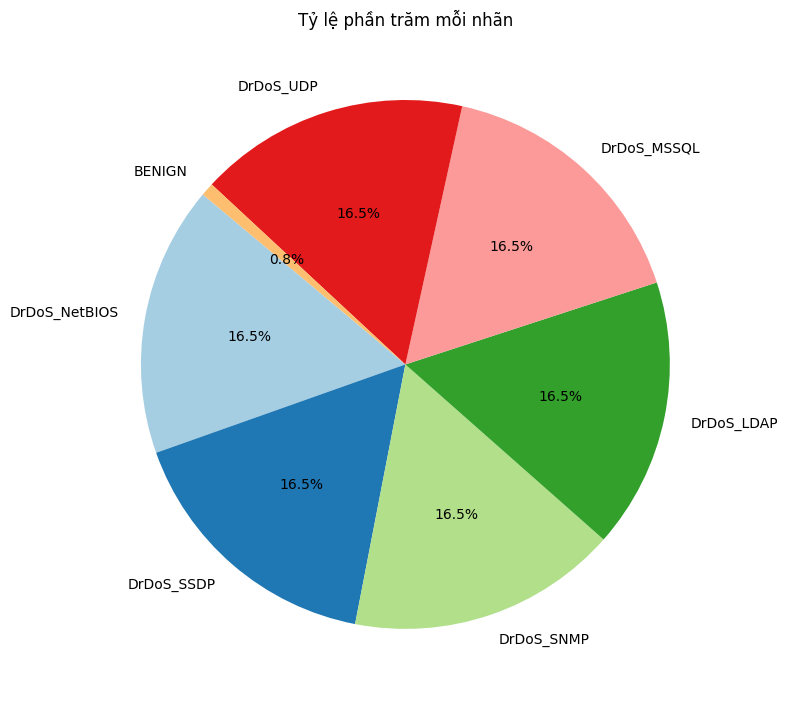

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

output_file = "./processed_dataset.csv"

df = pd.read_csv(output_file, usecols=["label"])

label_counts = df["label"].value_counts()
print(" Số lượng mẫu theo nhãn:")
print(label_counts)

label_percent = (label_counts / label_counts.sum()) * 100
print("\n Tỷ lệ phần trăm mỗi nhãn:")
print(label_percent.round(2))

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Số lượng mẫu theo nhãn')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng mẫu')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
label_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Tỷ lệ phần trăm mỗi nhãn')
plt.ylabel('') 
plt.tight_layout()
plt.show()


In [10]:
import gc
gc.collect()

7398

C:\Users\VennDev\AppData\Local\Temp\ipykernel_528\2184731415.py:6: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./processed_dataset.csv")


 Dữ liệu đã được cân bằng bằng SMOTE và lưu tại: smote_balanced_dataset.csv


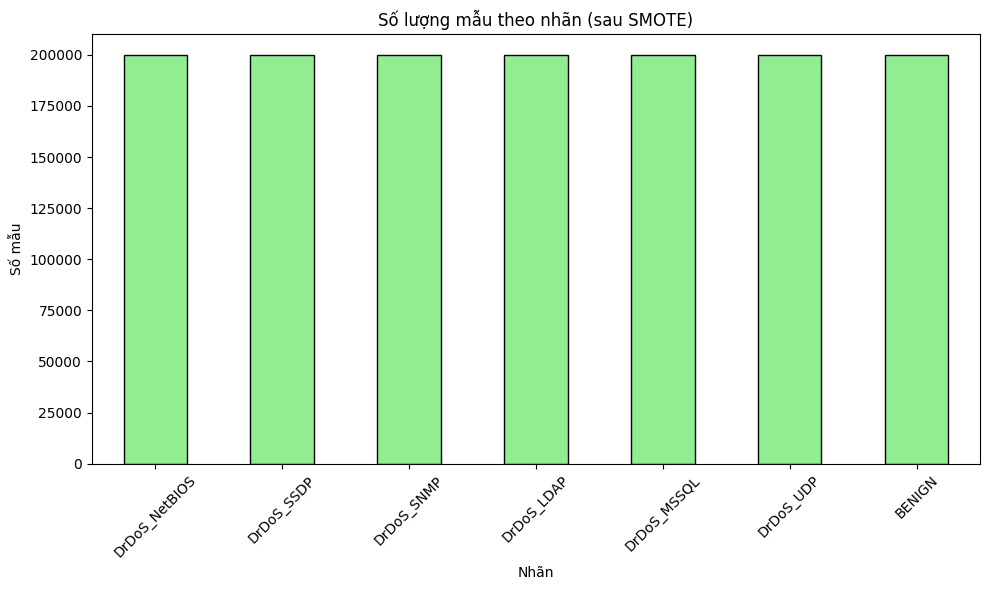

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

df = pd.read_csv("./processed_dataset.csv")

df_numeric = df.select_dtypes(include=["number"])

labels = df["label"]

X = df_numeric.copy()
y = labels

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

balanced_df = pd.DataFrame(X_resampled)
balanced_df["label"] = y_resampled

balanced_df.to_csv("./smote_balanced_dataset.csv", index=False)
print(" Dữ liệu đã được cân bằng bằng SMOTE và lưu tại: smote_balanced_dataset.csv")

plt.figure(figsize=(10, 6))
y_resampled.value_counts().plot(kind="bar", color="lightgreen", edgecolor="black")
plt.title("Số lượng mẫu theo nhãn (sau SMOTE)")
plt.xlabel("Nhãn")
plt.ylabel("Số mẫu")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
import gc
gc.collect()

4083

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib 

balanced_df = pd.read_csv("./smote_balanced_dataset.csv")

cols_to_drop = [
    "unnamed_0", "flow_id", "source_ip", "destination_ip",
    "source_port", "destination_port", "timestamp", "protocol"
]

balanced_df.drop(columns=cols_to_drop, inplace=True, errors='ignore') 

le = LabelEncoder()
y_encoded = le.fit_transform(balanced_df["label"])

X = balanced_df.drop("label", axis=1)
y = y_encoded

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

joblib.dump(X_train, 'X_train.pkl')
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(y_test, 'y_test.pkl')


['y_test.pkl']

In [17]:
import gc
gc.collect()

0

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import joblib

X_train = joblib.load('X_train.pkl')
X_test = joblib.load('X_test.pkl')
y_train = joblib.load('y_train.pkl')
y_test = joblib.load('y_test.pkl')


model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(set(y_train)), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        10,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,823 (73.53 KB)

 Trainable params: 18,823 (73.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=0.2)
model.save("my_model.keras")
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

print(" Mô hình đã được lưu vào 'my_model.keras'")

Epoch 1/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6368 - loss: 0.8175 - val_accuracy: 0.6992 - val_loss: 0.6205
Epoch 2/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6895 - loss: 0.6395 - val_accuracy: 0.6997 - val_loss: 0.6029
Epoch 3/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6945 - loss: 0.6211 - val_accuracy: 0.6997 - val_loss: 0.5980
Epoch 4/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6954 - loss: 0.6139 - val_accuracy: 0.7005 - val_loss: 0.5946
Epoch 5/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6956 - loss: 0.6096 - val_accuracy: 0.6976 - val_loss: 0.5977
Epoch 6/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6955 - loss: 0.6090 - val_accuracy: 0.6920 - val_loss: 0.5949
Epoch 7/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6960 - loss: 0.6058 - val_accuracy: 0.7003 - val_loss: 0.5899
Epoch 8/20
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6966 - loss: 0.6060 -

8750/8750 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7004 - loss: 0.5899
Test Accuracy: 0.7002


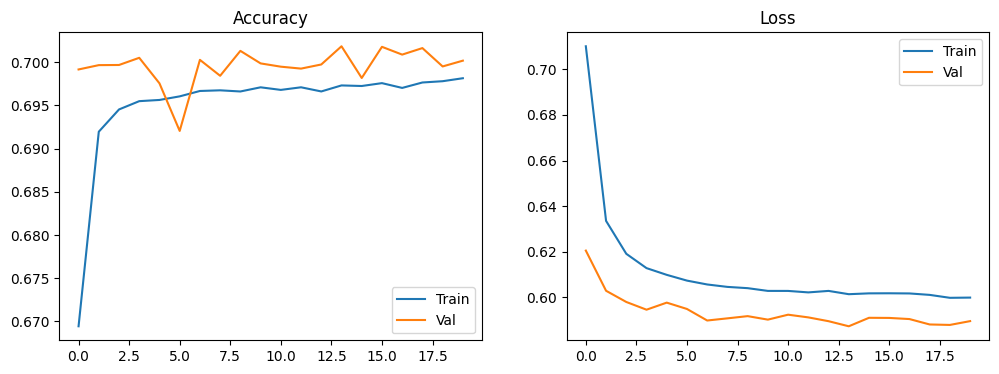

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.show()


8750/8750 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
               precision    recall  f1-score   support

       BENIGN       0.99      1.00      1.00     40000
   DrDoS_LDAP       0.80      0.98      0.88     40000
  DrDoS_MSSQL       0.73      0.80      0.77     40000
DrDoS_NetBIOS       0.82      0.06      0.11     40000
   DrDoS_SNMP       0.59      0.99      0.74     40000
   DrDoS_SSDP       0.58      0.18      0.27     40000
    DrDoS_UDP       0.55      0.90      0.69     40000

     accuracy                           0.70    280000
    macro avg       0.72      0.70      0.63    280000
 weighted avg       0.72      0.70      0.63    280000



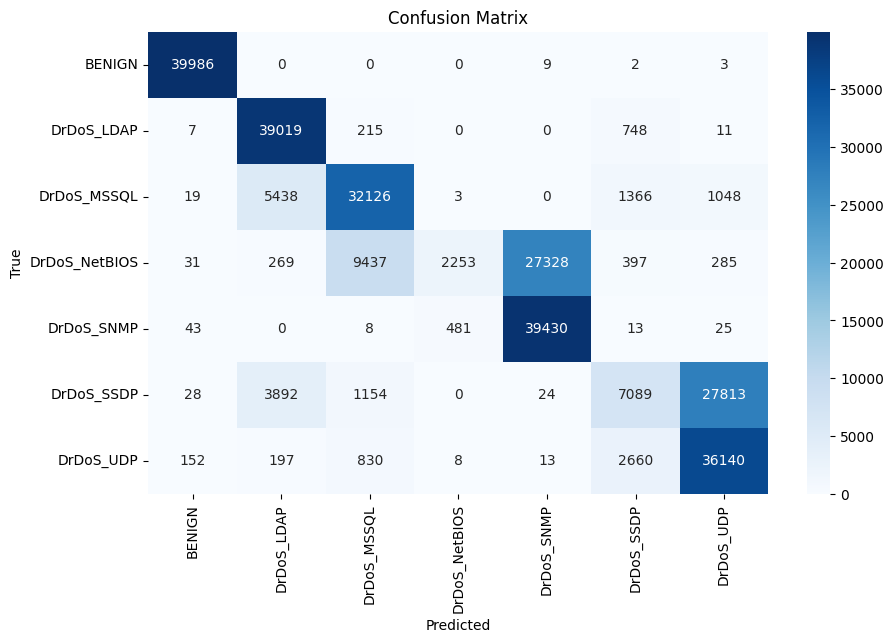

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
